In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install datasets

In [3]:
import torch.nn as nn
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim)

        # Non-linearity
        self.sigmoid = nn.Sigmoid()
        # Linear function (readout)
        # self.fc3 = nn.Linear(hidden_dim, output_dim)

        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 128)
        self.fc3 = nn.Linear(128, 64)
        # self.fc4 = nn.Linear(64,2)
        self.fc4 = nn.Linear(64,1)

    def forward(self, x):
        # Linear function  # LINEAR
        out = self.fc1(x)

        # # Non-linearity  # NON-LINEAR
        # out = self.sigmoid(out)
        # # Linear function (readout)  # LINEAR
        # out = self.fc2(out)

        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        # out = self.sigmoid(out)

        return out

In [82]:
from tqdm.notebook import tqdm
import numpy as np
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.data import DataLoader
import json
from matplotlib import pyplot as plt
import statistics

labels = []
with open("/content/gdrive/MyDrive/honest_llama/responses/llama_7B_cnn_dailymail_greedy_responses_labels_1000.json", 'r') as read_file:
    for line in read_file:
        data = json.loads(line)
        labels.append(1 if data['rougeL_to_target']>0.3 else 0)
np.sum(labels)

116

In [ ]:
data = []
with open("/content/gdrive/MyDrive/honest_llama/responses/llama_7B_cnn_dailymail_greedy_responses_1000.json", 'r') as read_file:
    for line in read_file:
        data.append(json.loads(line))
okay = [data[i] for i,l in enumerate(labels) if l>0.3 ]
not_okay = [data[i] for i,l in enumerate(labels) if l<0.3 ]
for val in okay:
  print(val['response1'])

In [ ]:
for val in not_okay:
  print(val['response1'])

In [65]:
num_layers = 32
mlp_dims = 4096

file_ends = [(a*20)+20 for a in range(int(1000/20))]
mlp_wise_activations = []
for file_end in file_ends:
    # mlp_wise_activations.append(np.load(f"/content/gdrive/MyDrive/honest_llama/features/llama_7B_cnn_dailymail_prompt_last_onwards_mlp_wise_{file_end}.pkl",allow_pickle=True)) # mlp final
    acts = np.load(f"/content/gdrive/MyDrive/honest_llama/features/llama_7B_cnn_dailymail_prompt_last_onwards_mlp_wise_{file_end}.pkl",allow_pickle=True) # mlp final
    # mlp_wise_activations.append(np.stack([act[:,-1,:] for act in acts], axis=0)) # only last token
    mlp_wise_activations.append(np.stack([act[:,0,:] for act in acts], axis=0)) # only first token
    # mlp_wise_activations.append(np.stack([np.mean(act,axis=1) for act in acts], axis=0)) # avg across all tokens
    # mlp_wise_activations.append(np.stack([np.max(act,axis=1) for act in acts], axis=0)) # max across all tokens
mlp_wise_activations = np.concatenate(mlp_wise_activations, axis=0)
assert mlp_wise_activations.shape[1:] == (32, mlp_dims)
assert len(labels)==len(mlp_wise_activations)

In [ ]:
num_layers = 32
num_heads = 32
ah_dims = 128

file_ends = [(a*20)+20 for a in range(int(1000/20))]
ah_wise_activations = []
for file_end in file_ends:
    acts = np.load(f"/content/gdrive/MyDrive/honest_llama/features/llama_7B_cnn_dailymail_prompt_last_onwards_head_wise_{file_end}.pkl",allow_pickle=True)
    # ah_wise_activations.append(np.stack([act[:,-1,:] for act in acts], axis=0)) # only last token
    ah_wise_activations.append(np.stack([act[:,0,:] for act in acts], axis=0)) # only first token
    # ah_wise_activations.append(np.stack([np.mean(act,axis=1) for act in acts], axis=0)) # avg across all tokens
    # ah_wise_activations.append(np.stack([np.max(act,axis=1) for act in acts], axis=0)) # max across all tokens
ah_wise_activations = np.concatenate(ah_wise_activations, axis=0)
assert ah_wise_activations.shape[1:] == (32, 4096)
assert len(labels)==len(ah_wise_activations)
ah_wise_activations = np.reshape(ah_wise_activations,(ah_wise_activations.shape[0],num_layers,num_heads,ah_dims))

In [ ]:
import numpy as np
np.random.seed(42)
num_folds = 1
using_act = 'mlp'
non_linear = True
using_chosen_dims = False

# Individual probes
len_dataset = len(mlp_wise_activations) if using_act == 'mlp' else len(ah_wise_activations)

all_val_accs = {}
all_val_f1s = {}
all_test_accs = {}
all_test_f1s = {}
all_test_preds = {}
y_true_test = {}
fold_idxs = np.array_split(np.arange(len_dataset), num_folds) # When using 2-fold CV
train_idxs = np.random.choice(np.arange(len_dataset), size=int(len(labels)*(1-0.2)), replace=False) # When using all data
test_idxs = np.array([x for x in np.arange(len_dataset) if x not in train_idxs]) # When using all data
for i in range(num_folds):
    train_idxs = np.concatenate([fold_idxs[j] for j in range(num_folds) if j != i]) if num_folds>1 else train_idxs
    test_idxs = fold_idxs[i] if num_folds>1 else test_idxs
    train_set_idxs = np.random.choice(train_idxs, size=int(len(train_idxs)*(1-0.2)), replace=False)
    val_set_idxs = np.array([x for x in train_idxs if x not in train_set_idxs])

    tot = len(test_idxs)
    print('baseline accuracy:',max(sum([labels[i] for i in test_idxs])
                                  ,tot-sum([labels[i] for i in test_idxs])
                                  )/tot)
    print('baseline f1:',f1_score([labels[i] for i in test_idxs],[1 for i in test_idxs]))

    if using_act == 'mlp':
        all_X_train = np.stack([mlp_wise_activations[i] for i in train_set_idxs], axis = 0)
        all_X_val = np.stack([mlp_wise_activations[i] for i in val_set_idxs], axis = 0)
        all_X_test = np.stack([mlp_wise_activations[i] for i in test_idxs], axis = 0)
    else:
        all_X_train = np.stack([ah_wise_activations[i] for i in train_set_idxs], axis = 0)
        all_X_val = np.stack([ah_wise_activations[i] for i in val_set_idxs], axis = 0)
        all_X_test = np.stack([ah_wise_activations[i] for i in test_idxs], axis = 0)
    y_train = np.stack([labels[i] for i in train_set_idxs], axis = 0)
    y_val = np.stack([labels[i] for i in val_set_idxs], axis = 0)
    y_test = np.stack([labels[i] for i in test_idxs], axis = 0)
    y_true_test[i] = y_test
    if non_linear:
        # y_train = np.vstack([np.array([0,1]) if val==1 else (1,0) for val in y_train], dtype='float32')
        # y_val = np.vstack([np.array([0,1]) if val==1 else (1,0) for val in y_val], dtype='float32')
        # y_test = np.vstack([np.array([0,1]) if val==1 else (1,0) for val in y_test], dtype='float32')
        y_train = np.vstack([[val] for val in y_train], dtype='float32')
        y_val = np.vstack([[val] for val in y_val], dtype='float32')
        y_test = np.vstack([[val] for val in y_test], dtype='float32')

    all_val_accs[i] = []
    all_val_f1s[i] = []
    all_test_accs[i] = []
    all_test_f1s[i] = []
    all_test_preds[i] = []
    loop_layers = list(chosen_dims.keys()) if using_chosen_dims else range(num_layers)
    for layer in tqdm(loop_layers):
      loop_heads = range(num_heads) if using_act == 'ah' else [0]
      for head in loop_heads:
        if using_act == 'mlp':
            X_train = np.squeeze(np.take(np.squeeze(all_X_train[:,layer,:]), chosen_dims[layer], axis=1)) if using_chosen_dims else all_X_train[:,layer,:]
            X_val = np.squeeze(np.take(np.squeeze(all_X_val[:,layer,:]), chosen_dims[layer], axis=1)) if using_chosen_dims else all_X_val[:,layer,:]
            X_test = np.squeeze(np.take(np.squeeze(all_X_test[:,layer,:]), chosen_dims[layer], axis=1)) if using_chosen_dims else all_X_test[:,layer,:]
        else:
            X_train = all_X_train[:,layer,head,:]
            X_val = all_X_val[:,layer,head,:]
            X_test = all_X_test[:,layer,head,:]

        if not non_linear:
            wgt_0 = np.sum(y_train)/len(y_train) # class 0 should get low wgt since number of 1s is very low
            clf = LogisticRegression(random_state=42, max_iter=1000, class_weight={0:wgt_0,1:1-wgt_0}).fit(X_train, y_train)
            y_val_pred = clf.predict(X_val)
            all_val_accs[i].append(accuracy_score(y_val, y_val_pred))
            all_val_f1s[i].append(f1_score(y_val, y_val_pred))
            y_test_pred = clf.predict(X_test)
            all_test_accs[i].append(accuracy_score(y_test, y_test_pred))
            all_test_f1s[i].append(f1_score(y_test, y_test_pred))
            all_test_preds[i].append(clf.predict_proba(X_test))
        else:
            train_target = np.stack([labels[i] for i in train_set_idxs], axis = 0)
            class_sample_count = np.array([len(np.where(train_target == t)[0]) for t in np.unique(train_target)])
            weight = 1. / class_sample_count
            samples_weight = torch.from_numpy(np.array([weight[t] for t in train_target])).double()
            sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
            ds_train = Dataset.from_dict({"inputs": X_train, "labels": y_train}).with_format("torch")
            ds_train = DataLoader(ds_train, batch_size=4,sampler=sampler)
            ds_val = Dataset.from_dict({"inputs": X_val, "labels": y_val}).with_format("torch")
            ds_val = DataLoader(ds_val, batch_size=4)
            ds_test = Dataset.from_dict({"inputs": X_test, "labels": y_test}).with_format("torch")
            ds_test = DataLoader(ds_test, batch_size=4)

            input_dim = mlp_dims if using_act=='mlp' else ah_dims # len(chosen_dims[layer]) # 4096
            hidden_dim = 256
            output_dim = 1

            model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)
            criterion = nn.BCEWithLogitsLoss(pos_weight = torch.tensor(np.sum(y_train)/(len(y_train)-np.sum(y_train)))) # nn.BCELoss() # nn.CrossEntropyLoss()
            lr = 0.05
            iter_bar = tqdm(ds_train, desc='Train Iter (loss=X.XXX)')

            for epoch in range(10):
              model.train()
              optimizer = torch.optim.SGD(model.parameters(), lr=lr)
              for step,batch in enumerate(iter_bar):
                  optimizer.zero_grad()
                  outputs = model(batch['inputs'])
                  loss = criterion(outputs, batch['labels'])
                  iter_bar.set_description('Train Iter (loss=%5.3f)' % loss.item())
                  loss.backward()
                  optimizer.step()
              lr = lr*0.9
            pred_correct = 0
            y_val_pred = []
            with torch.no_grad():
              model.eval()
              for step,batch in enumerate(ds_val):
                  outputs = model(batch['inputs'])
                  predicted = [1 if pred[0]>0.5 else 0 for pred in nn.Sigmoid()(outputs.data).tolist()]
                  actual = np.squeeze(batch['labels']).tolist()
                  pred_correct += sum([1 if p==a else 0 for p,a in zip(predicted, actual)])
                  y_val_pred += predicted
            # print('Validation Acc:',pred_correct/len(X_val))
            all_val_accs[i].append(pred_correct/len(X_val))
            all_val_f1s[i].append(f1_score([labels[i] for i in val_set_idxs],y_val_pred))
            pred_correct = 0
            y_test_pred = []
            with torch.no_grad():
              model.eval()
              for step,batch in enumerate(ds_test):
                  outputs = model(batch['inputs'])
                  predicted = [1 if pred[0]>0.5 else 0 for pred in nn.Sigmoid()(outputs.data).tolist()]
                  actual = np.squeeze(batch['labels']).tolist()
                  pred_correct += sum([1 if p==a else 0 for p,a in zip(predicted, actual)])
                  y_test_pred += predicted
            # print('Validation Acc:',pred_correct/len(X_test))
            all_test_accs[i].append(pred_correct/len(X_test))
            all_test_f1s[i].append(f1_score([labels[i] for i in test_idxs],y_test_pred))

In [100]:
for fold in range(num_folds):
    print('Avg:',np.mean(all_test_accs[fold]),np.mean(all_test_f1s[fold]))
    best, best_f1 = np.argmax(all_val_accs[fold]), np.argmax(all_val_f1s[fold])
    print('Best:',all_test_accs[fold][best],'Layer:',best, all_test_f1s[fold][best_f1],'Layer:',best_f1)

Avg: 0.905625 0.022034012183468708
Best: 0.91 Layer: 0 0.21428571428571427 Layer: 21


0.875 Layer: 23 0.13793103448275862


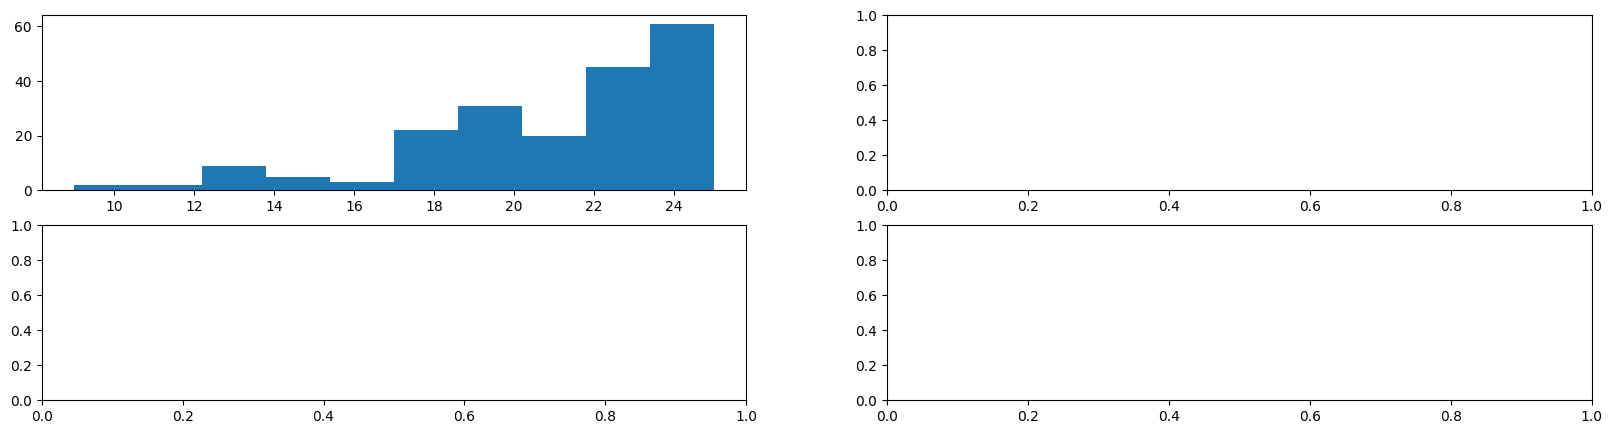

In [96]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 5))
confident_probe, confident_sample_pred = {}, {}
for fold in range(num_folds):
    confident_probe[fold], confident_sample_pred[fold] = [], []
    test_preds = np.stack(all_test_preds[fold])
    for i in range(test_preds.shape[1]):
        sample_pred = np.squeeze(test_preds[:,i,:])
        probe_wise_entropy = (-sample_pred*np.log2(sample_pred)).sum(axis=1)[:26]
        confident_probe[fold].append(np.argmin(probe_wise_entropy))
        confident_sample_pred[fold].append(np.argmax(sample_pred[np.argmin(probe_wise_entropy)]))
    print(np.sum(y_true_test[fold]==confident_sample_pred[fold])/len(y_true_test[fold]), 'Layer:', statistics.mode(confident_probe[fold]), f1_score(y_true_test[fold],confident_sample_pred[fold]))
    axes[0,fold].hist(confident_probe[fold])

In [97]:
import numpy as np
np.random.seed(42)
num_folds = 1
using_act = 'mlp'

# Single probe
len_dataset = len(mlp_wise_activations) if using_act == 'mlp' else len(ah_wise_activations)

fold_idxs = np.array_split(np.arange(len_dataset), 2)# When using 2-fold CV
train_idxs = np.random.choice(np.arange(len_dataset), size=int(len(labels)*(1-0.2)), replace=False) # When using all data
test_idxs = np.array([x for x in np.arange(len_dataset) if x not in train_idxs]) # When using all data
for i in range(num_folds):
    train_idxs = np.concatenate([fold_idxs[j] for j in range(num_folds) if j != i]) if num_folds>1 else train_idxs
    test_idxs = fold_idxs[i] if num_folds>1 else test_idxs
    train_set_idxs = np.random.choice(train_idxs, size=int(len(train_idxs)*(1-0.2)), replace=False)
    val_set_idxs = np.array([x for x in train_idxs if x not in train_set_idxs])

    tot = len(test_idxs)
    print('baseline accuracy:',max(sum([labels[i] for i in test_idxs])
                                  ,tot-sum([labels[i] for i in test_idxs])
                                  )/tot)
    print('baseline f1:',f1_score([labels[i] for i in test_idxs],[1 for i in test_idxs]))

    if using_act == 'mlp':
        all_X_train = np.stack([mlp_wise_activations[i] for i in train_set_idxs], axis = 0)
        all_X_val = np.stack([mlp_wise_activations[i] for i in val_set_idxs], axis = 0)
        all_X_test = np.stack([mlp_wise_activations[i] for i in test_idxs], axis = 0)
    else:
        all_X_train = np.stack([ah_wise_activations[i] for i in train_set_idxs], axis = 0)
        all_X_val = np.stack([ah_wise_activations[i] for i in val_set_idxs], axis = 0)
        all_X_test = np.stack([ah_wise_activations[i] for i in test_idxs], axis = 0)
    y_train = np.stack([labels[i] for i in train_set_idxs], axis = 0)
    y_val = np.stack([labels[i] for i in val_set_idxs], axis = 0)
    y_test = np.stack([labels[i] for i in test_idxs], axis = 0)
    y_true_test[i] = y_test
    # y_train = np.vstack([np.array([0,1]) if val==1 else (1,0) for val in y_train], dtype='float32')
    # y_val = np.vstack([np.array([0,1]) if val==1 else (1,0) for val in y_val], dtype='float32')

    all_val_accs[i] = []
    all_test_accs[i] = []
    all_test_preds[i] = []
    if using_act == 'mlp':
        X_train = np.reshape(all_X_train,(all_X_train.shape[0],all_X_train.shape[1]*all_X_train.shape[2]))
        X_val = np.reshape(all_X_val,(all_X_val.shape[0],all_X_val.shape[1]*all_X_val.shape[2]))
        X_test = np.reshape(all_X_test,(all_X_test.shape[0],all_X_test.shape[1]*all_X_test.shape[2]))
    else:
        X_train = np.reshape(all_X_train,(all_X_train.shape[0],all_X_train.shape[1]*all_X_train.shape[2]*all_X_train.shape[3]))
        X_val = np.reshape(all_X_val,(all_X_val.shape[0],all_X_val.shape[1]*all_X_val.shape[2]*all_X_val.shape[3]))
        X_test = np.reshape(all_X_test,(all_X_test.shape[0],all_X_test.shape[1]*all_X_test.shape[2]*all_X_test.shape[3]))

    wgt_0 = np.sum(y_train)/len(y_train) # class 0 should get low wgt since number of 1s is very low (higher class-weight means you want to put more emphasis on a class)
    clf = LogisticRegression(random_state=42, max_iter=1000, class_weight={0:wgt_0,1:1-wgt_0}).fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    print(accuracy_score(y_test, y_test_pred))
    print(f1_score(y_test, y_test_pred))

0.915
0.32


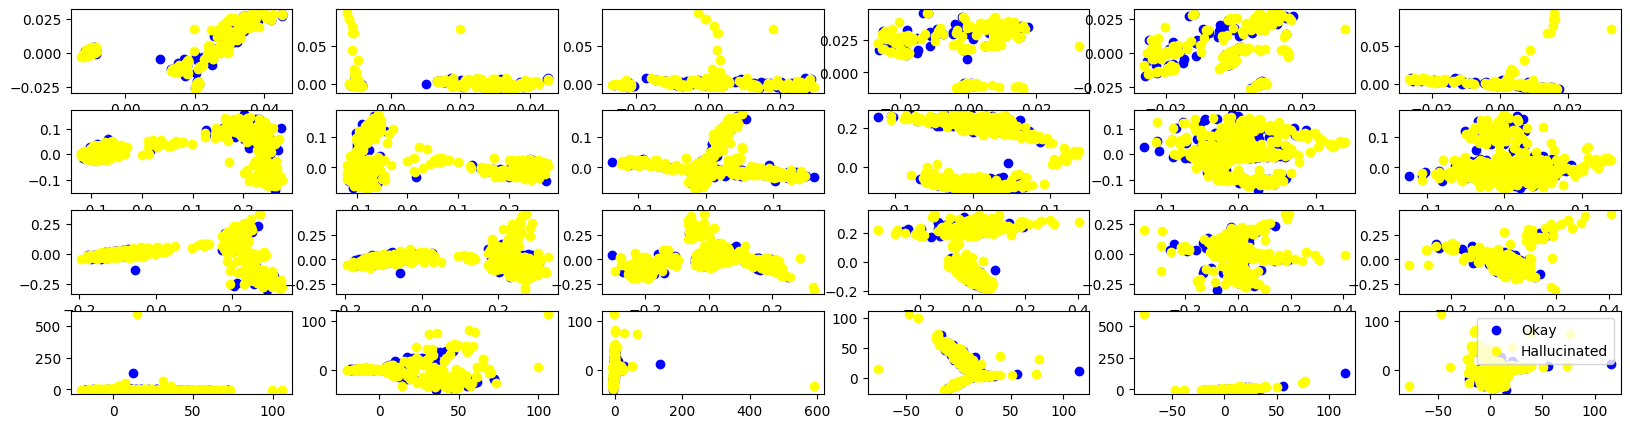

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

chosen_dims = {}
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 5))
# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 5),subplot_kw=dict(projection='3d'))
for i,layer in enumerate([0,11,22,31]): # range(32):
    layer_mlp_wise_activations = np.squeeze(mlp_wise_activations[:,layer,:])
    # # layer_mlp_wise_activations = (layer_mlp_wise_activations - layer_mlp_wise_activations.min())/(layer_mlp_wise_activations.max() - layer_mlp_wise_activations.min()) # is it okay to normalise across all dimensions?
    # truth_activations = np.vstack([layer_mlp_wise_activations[i,:] for i,label in enumerate(labels) if label==1])
    # false_activations = np.vstack([layer_mlp_wise_activations[i,:] for i,label in enumerate(labels) if label==0])
    # # print(layer,np.var(truth_activations),np.var(false_activations))
    # print(layer,angle_between(np.mean(truth_activations,axis=0),np.mean(false_activations,axis=0)))
    # act_diff = (np.max(truth_activations,axis=0)-np.max(false_activations,axis=0))/np.max(truth_activations,axis=0)
    # counts, bins = np.histogram(act_diff)
    # axes[i].stairs(counts, bins)
    # print(len(np.argwhere(act_diff > 0.3)))
    # chosen_dims[layer] = np.argwhere(act_diff > 0.3)

    pca = KernelPCA(n_components=4, kernel='poly') # PCA(n_components=3)
    transformed = pd.DataFrame(pca.fit_transform(layer_mlp_wise_activations))
    axes[i,0].scatter(transformed[np.array(labels)==1][0], transformed[np.array(labels)==1][1], label='Okay', c='blue')
    axes[i,0].scatter(transformed[np.array(labels)==0][0], transformed[np.array(labels)==0][1], label='Hallucinated', c='yellow')
    axes[i,1].scatter(transformed[np.array(labels)==1][0], transformed[np.array(labels)==1][2], label='Okay', c='blue')
    axes[i,1].scatter(transformed[np.array(labels)==0][0], transformed[np.array(labels)==0][2], label='Hallucinated', c='yellow')
    axes[i,2].scatter(transformed[np.array(labels)==1][1], transformed[np.array(labels)==1][2], label='Okay', c='blue')
    axes[i,2].scatter(transformed[np.array(labels)==0][1], transformed[np.array(labels)==0][2], label='Hallucinated', c='yellow')
    axes[i,3].scatter(transformed[np.array(labels)==1][3], transformed[np.array(labels)==1][0], label='Okay', c='blue')
    axes[i,3].scatter(transformed[np.array(labels)==0][3], transformed[np.array(labels)==0][0], label='Hallucinated', c='yellow')
    axes[i,4].scatter(transformed[np.array(labels)==1][3], transformed[np.array(labels)==1][1], label='Okay', c='blue')
    axes[i,4].scatter(transformed[np.array(labels)==0][3], transformed[np.array(labels)==0][1], label='Hallucinated', c='yellow')
    axes[i,5].scatter(transformed[np.array(labels)==1][3], transformed[np.array(labels)==1][2], label='Okay', c='blue')
    axes[i,5].scatter(transformed[np.array(labels)==0][3], transformed[np.array(labels)==0][2], label='Hallucinated', c='yellow')
    # # 3d
    # axes[i].scatter(transformed[labels==1][0], transformed[labels==1][1], transformed[labels==1][2], label='Truthful', c='blue')
    # axes[i].scatter(transformed[labels==0][0], transformed[labels==0][1], transformed[labels==0][2], label='Non-truthful', c='yellow')
    # break
plt.legend()
plt.show()

0.9860244989395142
0.9507715702056885
1.3630714416503906


0.9588750004768372


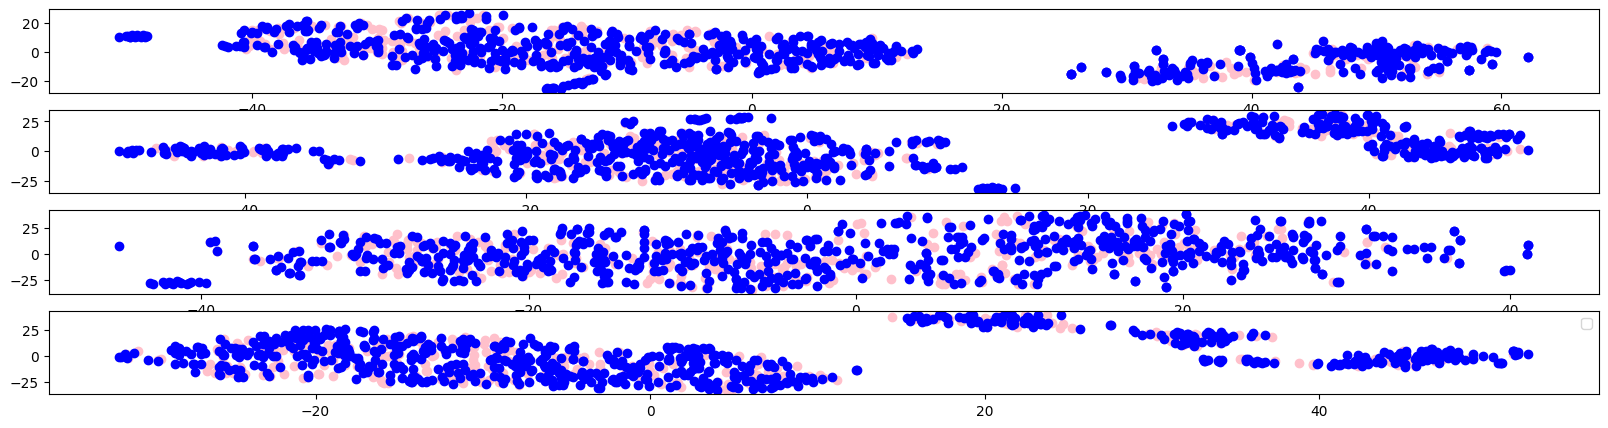

In [ ]:
from sklearn.manifold import TSNE

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 5))
for i,layer in enumerate([0,11,22,31]):
    layer_mlp_wise_activations = np.squeeze(mlp_wise_activations[:,layer,:])
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(layer_mlp_wise_activations)
    print(tsne.kl_divergence_)
    axes[i].scatter(x=X_tsne[np.array(labels)==1, 0], y=X_tsne[np.array(labels)==1, 1], color='pink')
    axes[i].scatter(x=X_tsne[np.array(labels)==0, 0], y=X_tsne[np.array(labels)==0, 1], color='blue')
plt.legend()
plt.show()